In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import rc_context

## load starfysh

In [2]:
from starfysh import (utils,
                      plot_utils,
                      starfysh,
                      dataloader,
                      post_analysis
                      )

## load data and gene signature

In [3]:
# assign file path
data_folder = 'simu_data'
sample_id='simu_5'
sig_file_name = 'tnbc_signature.csv'

if data_folder =='simu_data':
    member = pd.read_csv(os.path.join(data_folder,sample_id,'members.st_synth.csv'),index_col=0)
    proportions = pd.read_csv(os.path.join(data_folder,sample_id,'proportions.st_synth.csv'),index_col=0)

In [4]:
adata_sample = utils.load_adata(data_folder,sample_id,n_genes=2000)

Preprocessing1: delete the mt and rp
Preprocessing2: Normalize


/usr/local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing3: Logarithm
Preprocessing4: Find the variable genes


In [5]:
## import gene signature and have specific preprocessing for this sig file
gene_sig = pd.read_csv(os.path.join(data_folder,sig_file_name))
gene_sig = gene_sig.iloc[:,[1,3,4,7,8]]
gene_sig.columns=['CAFs','Normal Epithelial','Myeloid','T-cells','Cancer Epithelial']
gene_sig = gene_sig.reindex(columns=['CAFs','Cancer Epithelial','Myeloid','Normal Epithelial','T-cells'])

## find anchor spots

In [6]:
adata_sample = utils.get_adata_wsig(adata_sample, gene_sig)
sig_mean = utils.get_sig_mean(adata_sample, gene_sig)
pure_spots, pure_dict, pure_idx = utils.get_anchor_spots(adata_sample,
                                               sig_mean,
                                               v_low = 20, 
                                               v_high = 95,
                                               n_anchor = 40
                                               )

the number of original variable genes in the dataset (2000,)
the number of siganture genes in the dataset (146,)
after filter out some genes in the signature not in the var_names ... (146,)
after filter out some genes not highly expressed in the signature ... (143,)
combine the varibale and siganture, the total unique gene number is ... 2008


/Users/siyuhe/03_Spatial_project/starfysh/utils.py:223: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pure_spots = np.transpose(sig_mean.loc[highq_spots,:].index[(-np.array(sig_mean.loc[highq_spots,:])).argsort(axis=0)[:40,:]])


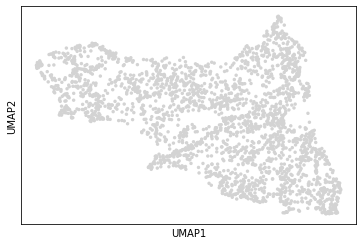

In [7]:
umap_df = utils.get_umap(adata_sample)

## visualize anchor spots

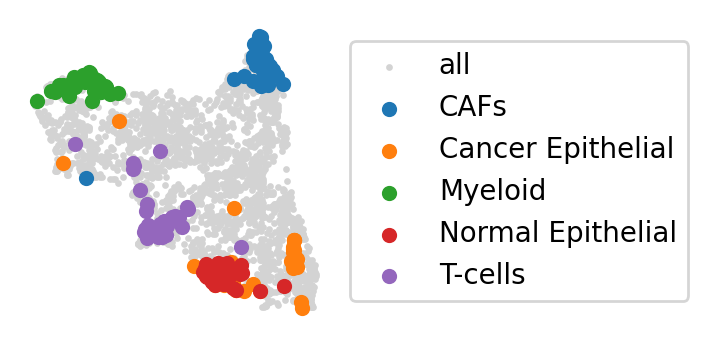

In [8]:
plot_utils.plot_anchor_spots(umap_df,pure_spots,sig_mean)

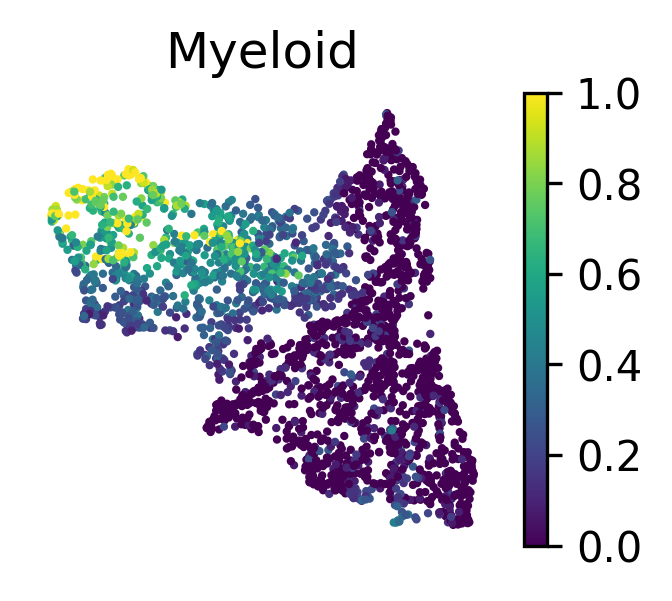

In [9]:
plot_utils.plot_proportions(umap_df,proportions,idx=2, cmap='viridis')

In [10]:
map_info = utils.get_simu_map_info(umap_df)
log_lib = np.log((adata_sample.to_df()).sum(axis=1))
win_loglib = utils.get_windowed_library(adata_sample,
                                  map_info,
                                  log_lib,
                                  window_size=35
                                 )

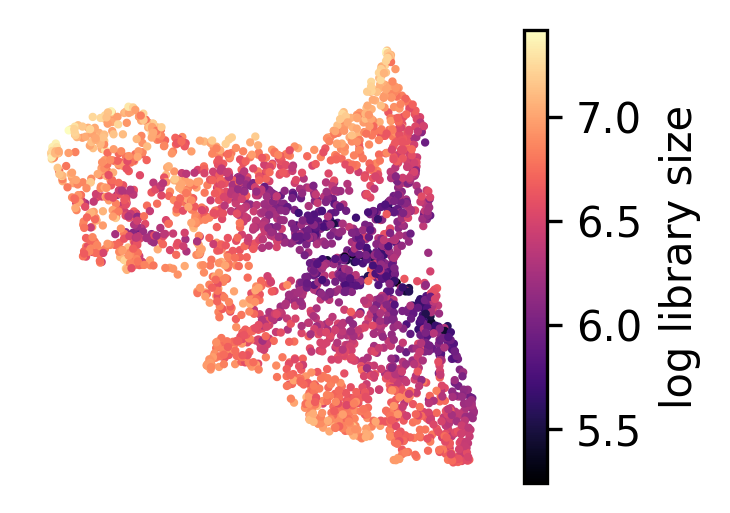

In [11]:
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 log_lib,
                 label='log library size'
                )

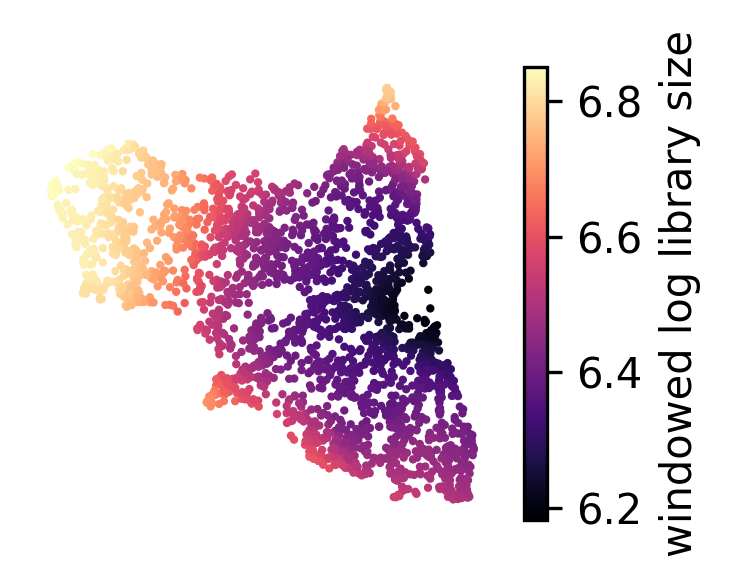

In [12]:
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 win_loglib,
                 label='windowed log library size'
                )

## Run model

In [13]:
model = starfysh.AVAE(
            adata = adata_sample,
            gene_sig = gene_sig
          )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

trainset = dataloader.VisiumDataset(adata=adata_sample, 
                                    gene_sig_exp_m=sig_mean,
                                    adata_pure = pure_idx,
                                    library_n = win_loglib
                                    )
trainloader = DataLoader(trainset, 
                         batch_size=32, 
                         shuffle=True)

epochs= 30
train_loss = []
corr_list_all = []
for epoch in range(epochs):
    (train_epoch_loss, 
     train_reconst, 
     train_z, 
     train_c, 
     train_n, 
     corr_list) = starfysh.train(model, 
                                 trainloader, 
                                 trainset, 
                                 device, 
                                 optimizer)
    
    train_loss.append(train_epoch_loss)
    torch.cuda.empty_cache()
    corr_list_all.append(corr_list)
    if (epoch+1) % 1 == 0:
            print ("Epoch[{}/{}], train_loss: {:.4f}, train_reconst: {:.4f}, train_z: {:.4f},train_c: {:.4f},train_n: {:.4f}".format(epoch+1, epochs, train_epoch_loss, train_reconst, train_z, train_c, train_n))  
print('finish lower training rate')

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'starfysh.starfysh.NegBinom'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch[1/30], train_loss: 1056.7261, train_reconst: 991.5936, train_z: 16.6064,train_c: 19.7459,train_n: 28.7802
Epoch[2/30], train_loss: 705.4039, train_reconst: 643.8300, train_z: 23.8947,train_c: 8.2131,train_n: 29.4661
Epoch[3/30], train_loss: 642.2427, train_reconst: 584.7897, train_z: 23.5140,train_c: 5.9507,train_n: 27.9883
Epoch[4/30], train_loss: 620.4199, train_reconst: 567.7327, train_z: 21.2415,train_c: 5.1974,train_n: 26.2484
Epoch[5/30], train_loss: 606.9866, train_reconst: 556.3014, train_z: 20.0592,train_c: 5.1184,train_n: 25.5076
Epoch[6/30], train_loss: 598.6041, train_reconst: 550.0459, train_z: 19.0465,train_c: 5.1135,train_n: 24.3982
Epoch[7/30], train_loss: 591.2508, train_reconst: 543.7944, train_z: 18.2836,train_c: 5.5989,train_n: 23.5739
Epoch[8/30], train_loss: 582.9090, train_reconst: 536.6246, train_z: 17.9578,train_c: 5.2697,train_n: 23.0568
Epoch[9/30], train_loss: 579.5107, train_reconst: 532.6560, train_z: 17.6148,train_c: 5.6921,train_n: 23.5477
Epoch[10

## Downstream Analysis

In [14]:
inference_outputs, generative_outputs, px = starfysh.model_eval(model,adata_sample, sig_mean, device)
u = post_analysis.get_z_umap(inference_outputs)

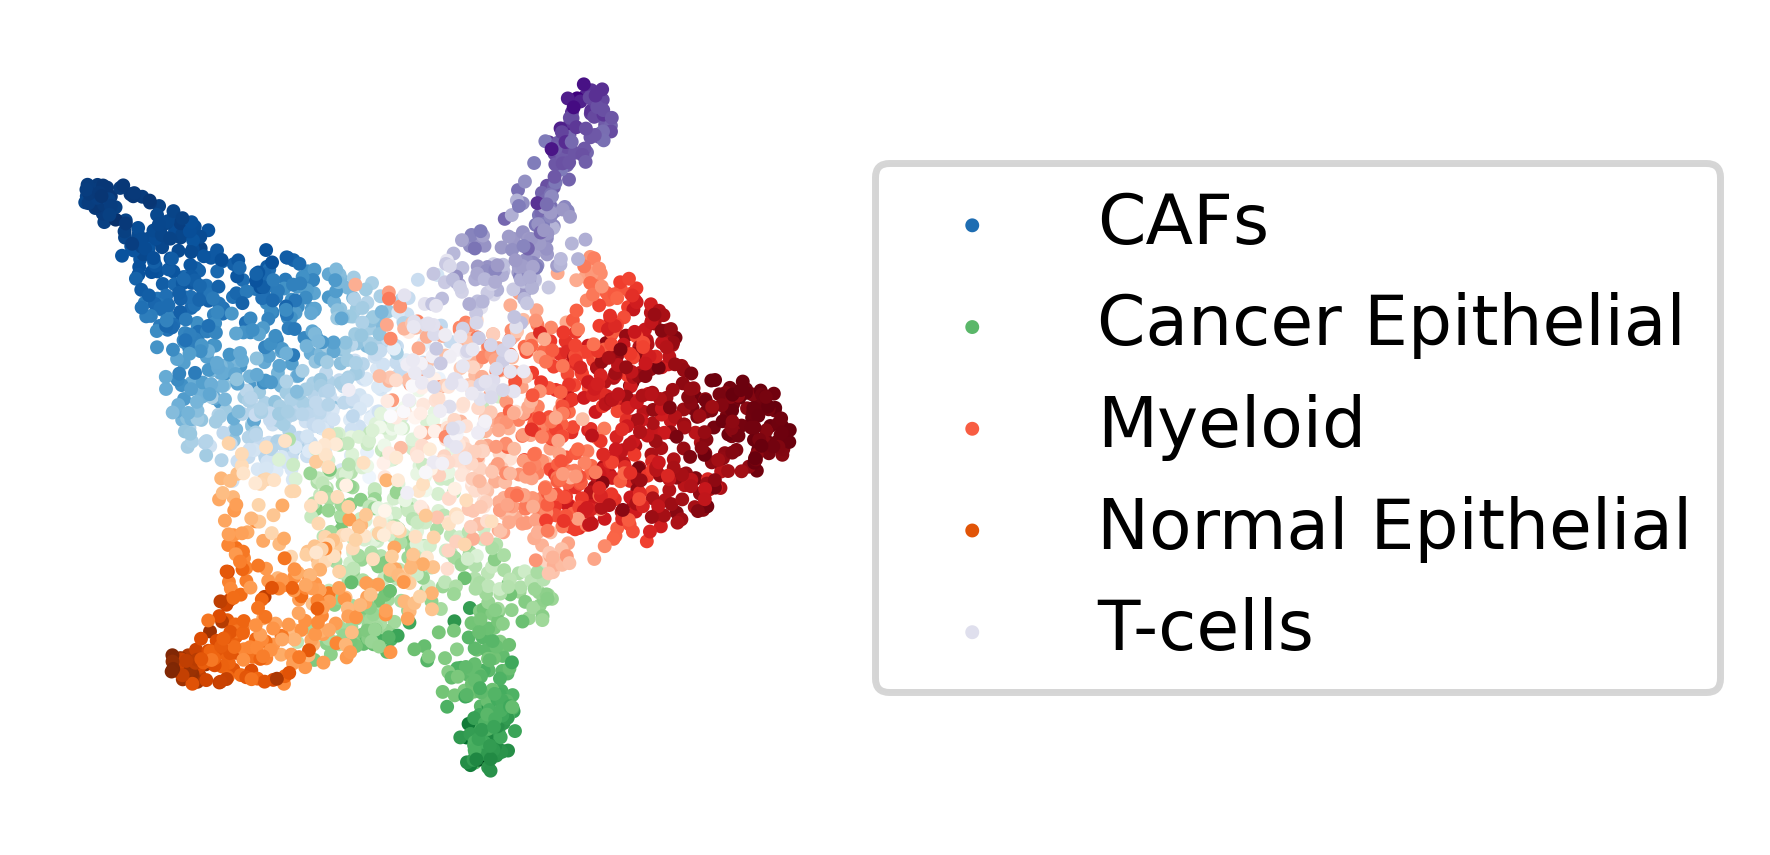

In [15]:
post_analysis.plot_type_all(inference_outputs,u,proportions)

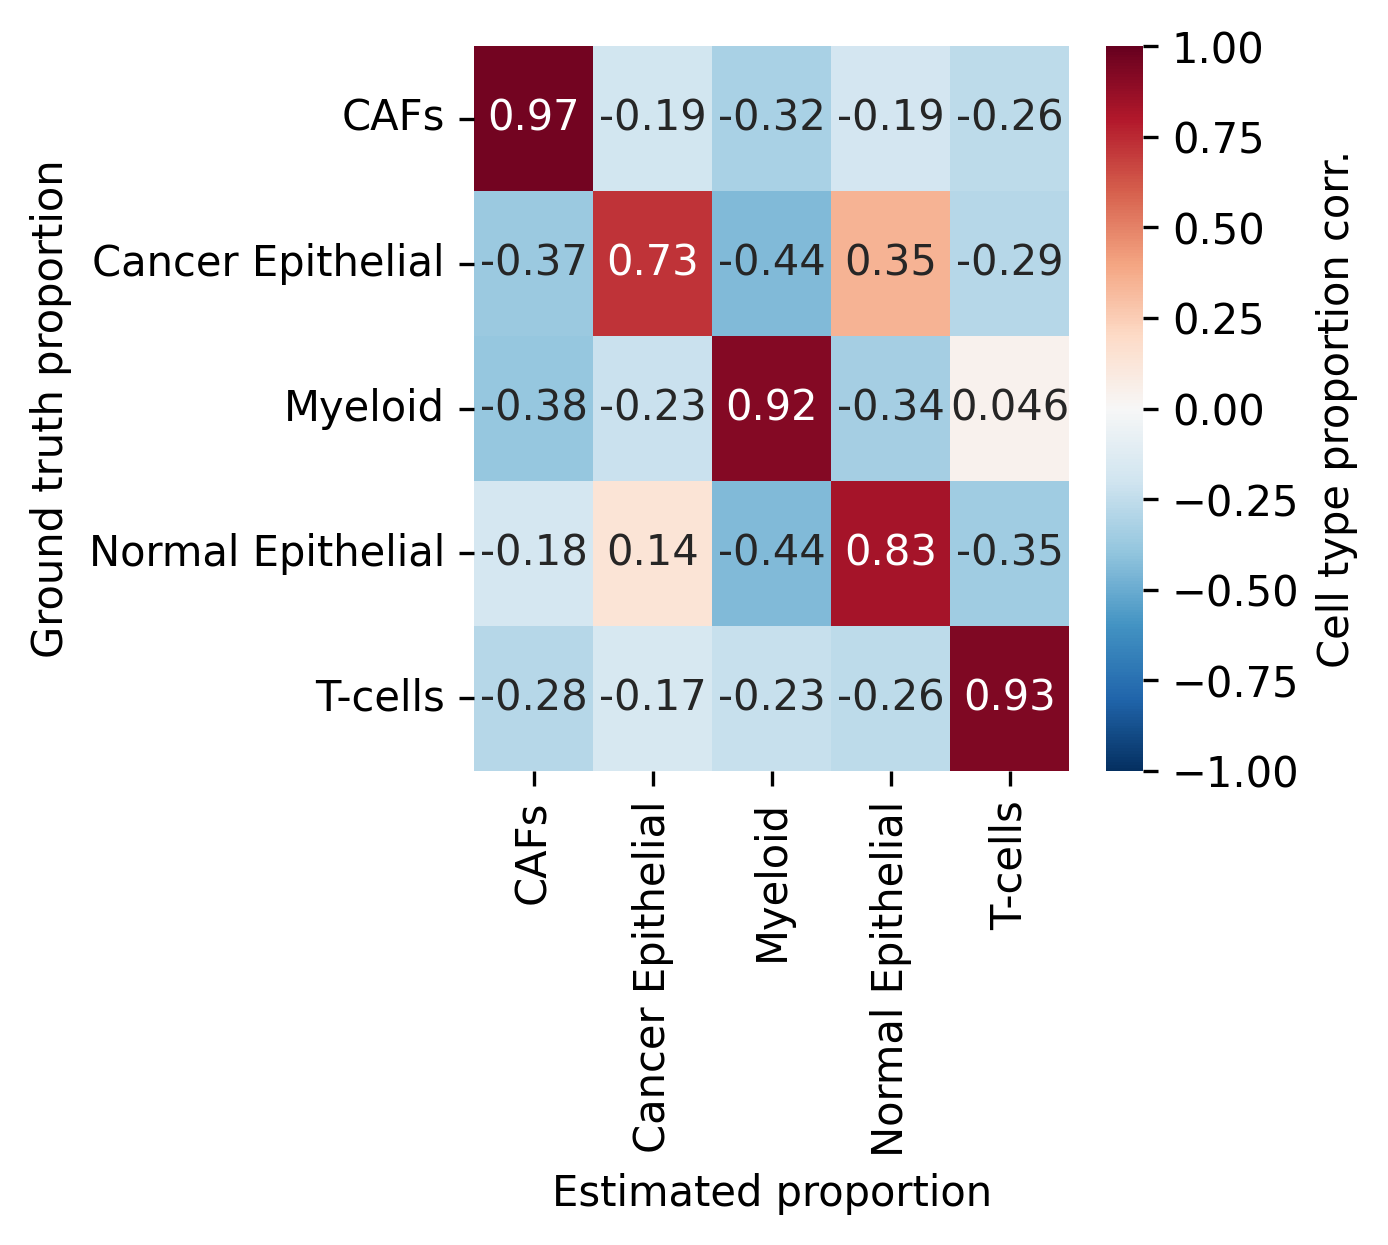

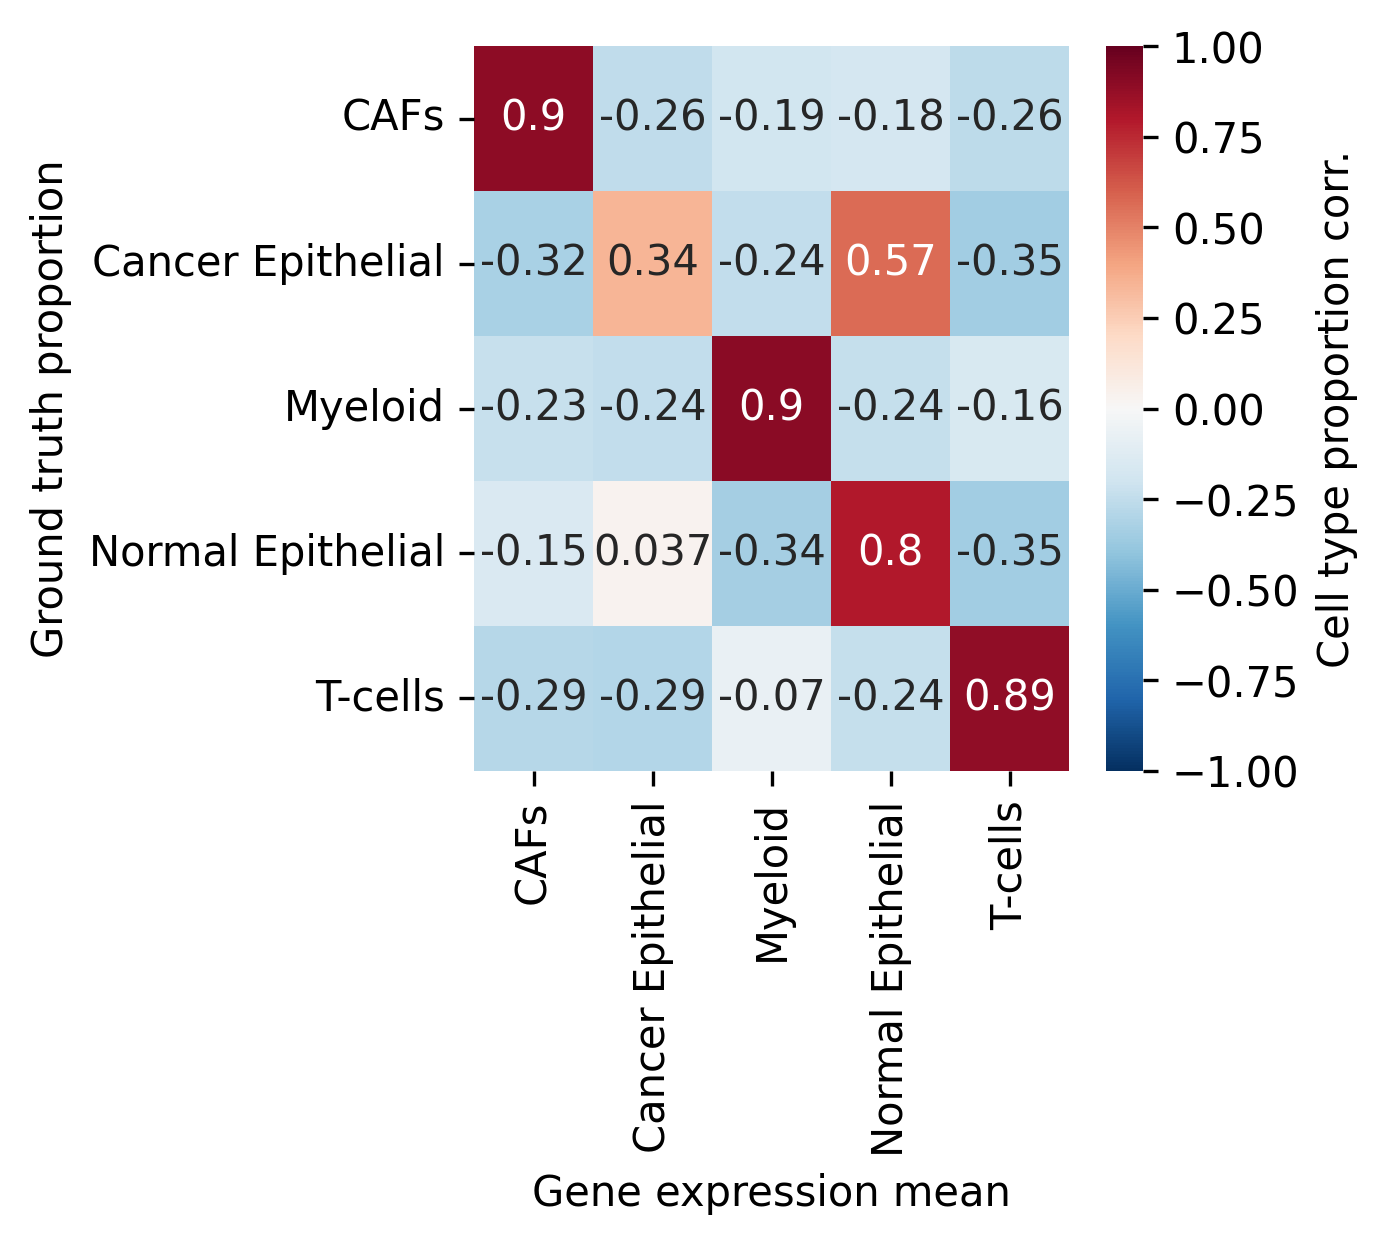

In [16]:
post_analysis.get_corr_map(inference_outputs,sig_mean,proportions)

In [46]:
proportions.iloc[:,4]>0

Spotx1        True
Spotx2        True
Spotx3       False
Spotx4        True
Spotx5        True
             ...  
Spotx2547    False
Spotx2548    False
Spotx2549    False
Spotx2550    False
Spotx2551    False
Name: T-cells, Length: 2551, dtype: bool

In [67]:
from scipy.stats import gaussian_kde
def pred_prop_scatter(inference_outputs, proportions,idx):
    qc_m = inference_outputs["qc_m"].detach().numpy()
    
    figs,ax=plt.subplots(1,1,dpi=300,figsize=(2,2))
    
    v1 = proportions.iloc[:,idx].values
    v2 = qc_m[:,idx]
    
    v_stacked = np.vstack([v1, v2])
    den = gaussian_kde(v_stacked)(v_stacked)
    
    ax.scatter(v1,v2,c=den,s=1,cmap='turbo',vmax=den.max()/3)
    
    ax.set_aspect('equal')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axis('equal')
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.title(proportions.columns[idx])
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xticks(np.arange(0,1.1,0.5))
    plt.yticks(np.arange(0,1.1,0.5))
    plt.xlabel('Ground truth proportions')
    plt.ylabel('Predicted proportions')

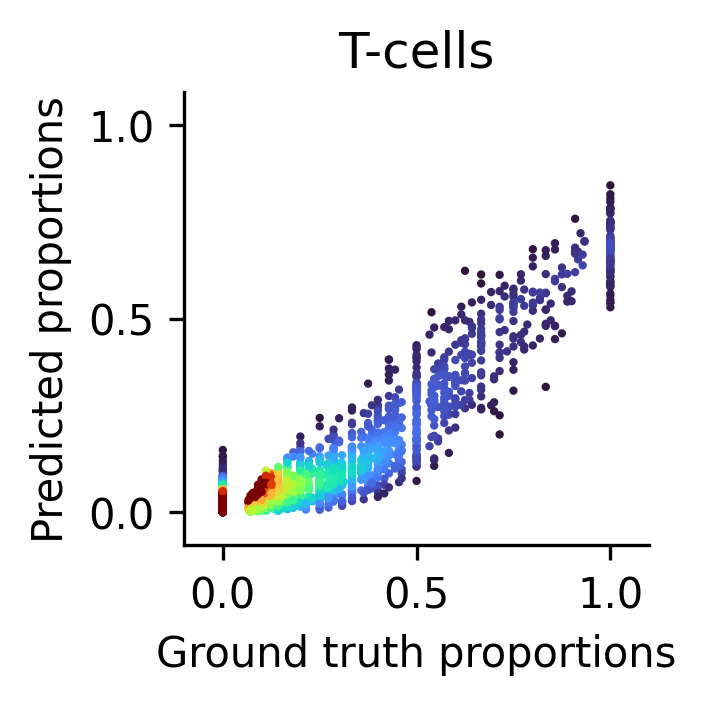

In [73]:
pred_prop_scatter(inference_outputs,proportions,idx=4)

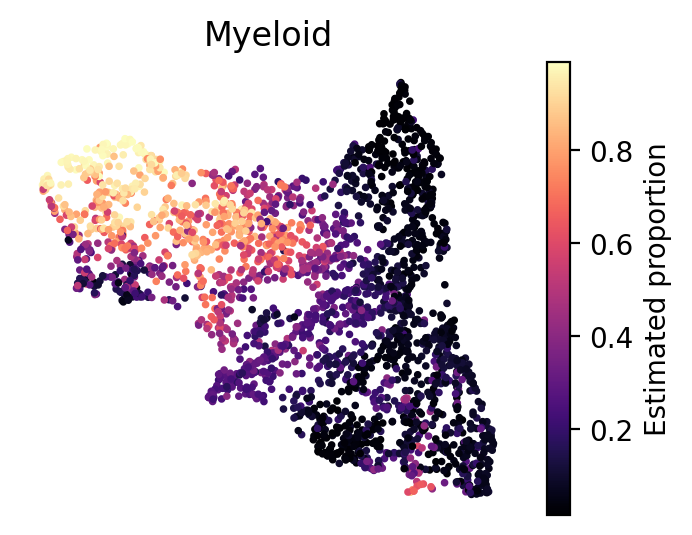

In [84]:
post_analysis.pl_spatial_feature(adata_sample,
                   map_info,
                   inference_outputs,
                   feature='qc_m',
                   idx=2,
                   plt_title=gene_sig.columns[idx],
                   label='Estimated proportion',
                   s=3,
                   )

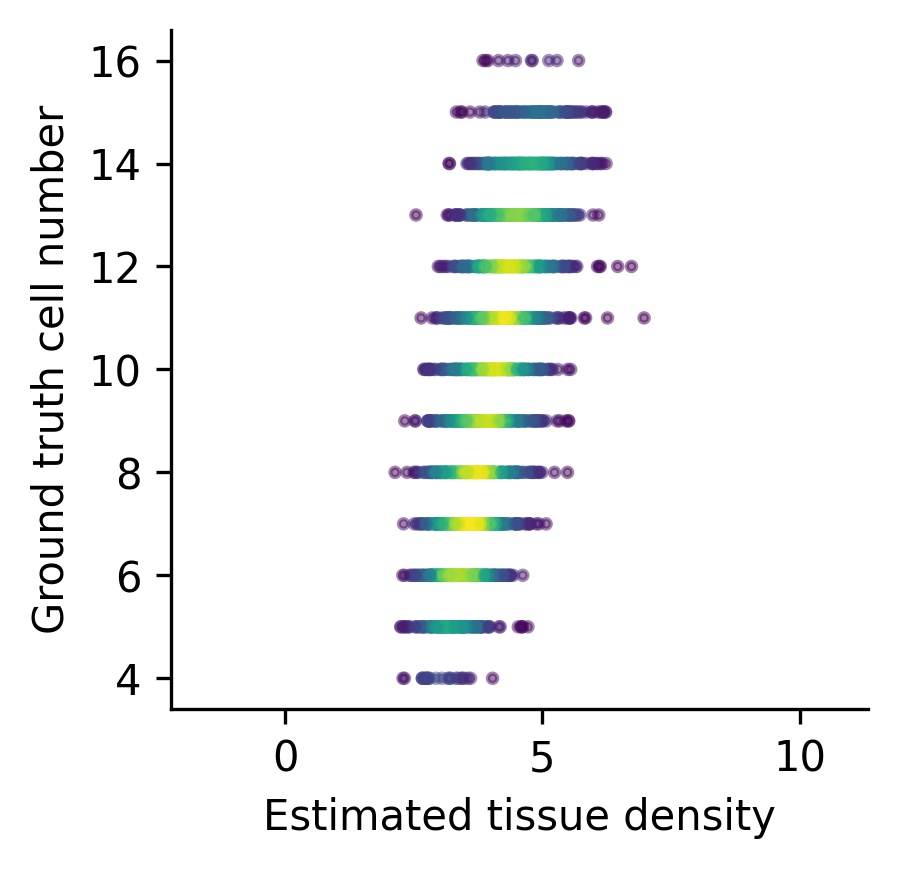

In [86]:
ql = inference_outputs['ql'].detach().numpy()
post_analysis.display_reconst(pd.DataFrame(np.exp(ql.flatten())),
                pd.DataFrame(np.array(member.sum(axis=1))) ,
                density=True,
                x_label='Estimated tissue density',
                y_label='Ground truth cell number',
                sample_rate=1,
                x_min=0,
                spot_size=5,
                    x_max=20,
                    y_min=0,
                    y_max=20,
               )

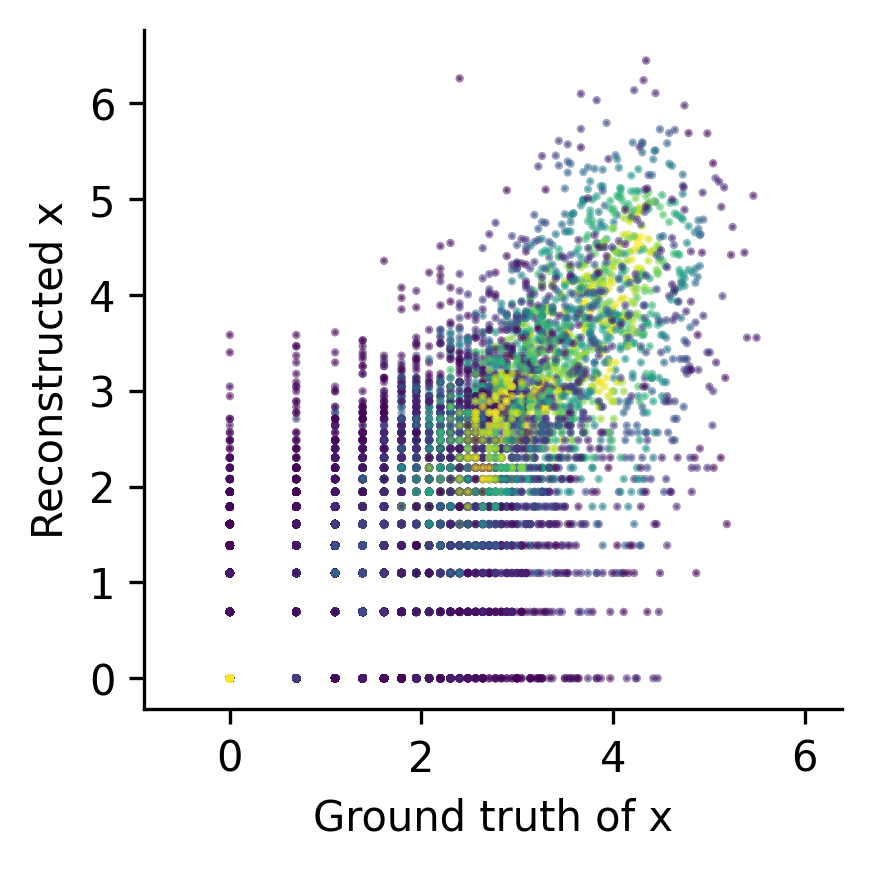

In [87]:
post_analysis.display_reconst(pd.DataFrame(np.log(np.array(adata_sample.to_df())+1)),
                pd.DataFrame(np.log(px+1)),
                density=True,
                x_label='Ground truth of x',
                y_label='Reconstructed x',
                x_min=0,
                x_max=8,
                y_min=0,
                y_max=8,
               )